#### Título: Inteligencia Artificial y aplicaciones de series de tiempo.

#### Objetivo: construir una Red Neuronal Recurrente de tipo (LSTM) para  análisis de series de tiempo

#### Fecha: 20191127

#### Referencia: gg20191127_RedNeuronal_LSTM_PrediccionNumerica_ConsumoElectrico.ipynb

#### Fuente de datos: Series de tiempo de consumo eléctrico en Francia.

#### Los datos se encuentran en el sitio de la Universidad de California Irving UCI:

http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Resumen: Medidas de consumo eléctrico de una casa con medidas por minuto en un intervalo de 4 años. Se ofrecen diferentes medidas del consumo eléctrico. El periodo es: diciembre 2006 a noviembre 2010, con un total de 47 meses.
	
Conjunto de datos: Serie de tiempo con varias características
	
Número de registros: 2075259
	
Fecha: 2012-08-30



##### Ejemplo de registro:  16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000

##### Los metadatos del conjunto de datos son: 

1.date: Fecha en formato dd / mm / aaaa => 16/12/2006

2.time: hora en formato hh: mm: ss => 17:24:00

3.global_active_power: potencia activa promediada por minuto (en kilovatios) => 4.216

4.global_reactive_power: potencia reactiva promediada por minuto (en kilovatios) => 0.418

5.voltaje: voltaje promediado por minuto (en voltios) => 234.840

6.global_intensity: intensidad de corriente promediada por minuto (en amperios) => 18.400

7.sub_metering_1: submétrica de energía_1 (en watt-hora de energía activa). Corresponde a la cocina => 0.000

8.sub_metering_2: submedición de energía_2 (en watt-hora de energía activa). Corresponde al cuarto de lavado => 1.000

9.sub_metering_3: submétrica de energía_3 (en watt-hora de energía activa). Corresponde a un calentador de agua eléctrico y al aire acondicionado => 17.000

En resumen, la serie de tiempo contiene 9 valores con unidades de medida diferentes.


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Se importan las bibliotecas de Python 

import sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import itertools

from scipy.stats import randint

from sklearn.model_selection import train_test_split # to split the data into two parts

from sklearn.model_selection import KFold # use for cross validation

from sklearn.preprocessing import StandardScaler # Para normalizacion

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline # pipeline making

from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectFromModel

from sklearn import metrics # for the check the error and accuracy of the model

from sklearn.metrics import mean_squared_error,r2_score


import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


Using TensorFlow backend.


## Importar el conjunto de datos de la serie de tiempo 

Se lee por medio de pandas y unen las columnas Date y Time para representar el tiempo en la serie de tiempo

Se lee indicando el caracter separador sep=';' 

Se indica que se unen las columnas Date y Time y se indica que debe ser una fecha

Se indica que la nueva columna denominada 'dt' es el indice



In [2]:
%%bash

ls -hl

total 127M
-rw-rw-r-- 1 saXsa saXsa  66K nov 27 21:17 gg20191127_RedNeuronal_LSTM_PrediccionNumerica_ConsumoElectrico.ipynb
-rw-r--r-- 1 saXsa saXsa 127M ago 30 13:59 household_power_consumption.txt
-rw-rw-rw- 6 saXsa saXsa  82K nov  8 19:10 jquery.min.js
-rw-rw-rw- 6 saXsa saXsa  15K nov  8 19:09 require.min.js


In [3]:
%%bash

wc -l household_power_consumption.txt

2075260 household_power_consumption.txt


In [4]:
%%bash 

head -2 household_power_consumption.txt

Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000


In [5]:
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['nan','?'], 
                 index_col='dt')

pandas.read_csv

Lectura de un archivo CSV (comma-separated) y creación de un DataFrame con la biblioteca Pandas

***sep : str, default ‘,’***

Caracter delimitador del archivo CSV.
    
parse_dates : boolean o lista de enteros o nombres o lista de listas o un dictionario dict, por omision False
    
Ejemplo: parse_dates={‘dt’ : ['Date', 'Time' ]} 

Se analizan (parsear) las columnas 'Date', 'Time' como fecha y se denomina el resultado como ‘dt’
    
infer_datetime_format : boolean, default False

If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in the columns, and if it can be inferred, switch to a faster method of parsing them. 

En ocasiones esta acción aumenta la velocidad del análisis (parseo) en magnitudes de 5 o 10 veces. 

low_memory : boolean, default True

Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. 

To ensure no mixed types either set False, or specify the type with the dtype parameter. 

Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser)


na_values : scalar, str, list-like, or dict, default None

Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values. By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, ‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, ‘n/a’, ‘nan’, ‘null’.


index_col : int or sequence or False, default None

Column to use as the row labels of the DataFrame. If a sequence is given, a MultiIndex is used. If you have a malformed file with delimiters at the end of each line, you might consider index_col=False to force pandas to _not_ use the first column as the index (row names)


Se identifican los valores no validos como 'nan' y  '?'  

Se mezclan las columnas 'Date' y 'Time' y se genera la columna 'dt'

Se genera una estructura de serie de tiempo creando el indice como la variable tiempo 'dt'  

In [18]:
df.head(1) 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [20]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [21]:
df.shape

(2075259, 7)

In [22]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [23]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [24]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

 DataFrame.iloc

    Purely integer-location based indexing for selection by position.

    .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
    
    Allowed inputs are:

    An integer, e.g. 5.
    A list or array of integers, e.g. [4, 3, 0].
    A slice object with ints, e.g. 1:7.
    A boolean array.
    A callable function with one argument (the calling Series, DataFrame or Panel) and that returns valid output for indexing (one of the above)
    
 pandas.unique(values)

 Hash table-based unique. Uniques are returned in order of appearance. This does NOT sort.

 Significantly faster than numpy.unique. Includes NA values.

Análisis de los valores que toma cada una de las características

In [25]:
for j in range(1,7):
       print(df.iloc[:, j].unique())

[0.418      0.436      0.498      0.502      0.528      0.522
 0.52       0.51       0.47       0.478      0.398      0.422
 0.282      0.152      0.156      0.         0.076      0.09
 0.2        0.058      0.18       0.144      0.118      0.108
 0.202      0.192      0.186      0.116      0.136      0.148
 0.16       0.158      0.1        0.082      0.05       0.052
 0.162      0.086      0.048      0.054      0.068      0.166
 0.174      0.178      0.188      0.088      0.08       0.07
 0.084      0.074      0.106      0.092      0.064      0.046
 0.138      0.134      0.132      0.12       0.13       0.154
 0.078      0.142      0.14       0.146      0.15       0.17
 0.102      0.072      0.06       0.056      0.062      0.112
 0.066      0.172      0.168      0.194      0.184      0.096
 0.164      0.182      0.094      0.098      0.176      0.19
 0.204      0.22       0.198      0.208      0.244      0.334
 0.298      0.296      0.286      0.278      0.104      0.258
 0.238      

[ 1.          2.          0.         16.         37.         36.
 22.         12.         27.         20.          9.          4.
  3.          5.         13.         35.         28.         26.
 24.         21.         17.         33.         25.         23.
 18.         30.         31.          7.         38.         29.
 50.         71.         59.         62.         70.         40.
 34.          8.         15.          6.         32.         19.
 14.         49.         72.         73.         61.         39.
 42.         10.         56.         11.          1.29851997 43.
 67.         63.         53.         65.         52.         69.
 48.         74.         41.         47.         58.         68.
 64.         75.         46.         57.         60.         66.
 44.         78.         77.         76.         51.         55.
 45.         54.         79.         80.        ]
[17.         16.         18.          9.          0.          5.
 19.         10.         20.          8.

#  Manipulando el valor faltante (missing values)  'nan' 

In [26]:
## Buscando las columnas que contengan algun valor 'nan'

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[]

Esto nos indica que todas las columnas contienen al menos un valor vacio 'nan'


DataFrame.fillna

Fill NA/NaN values using the specified method

filling nan with mean in any columns

In [27]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())


In [28]:
nueva_droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        nueva_droping_list_all.append(j)        
nueva_droping_list_all

[]

In [29]:
# Otra forma de verificar si existen campos sin valor
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [30]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [32]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [33]:
df.shape

(2075259, 7)

In [34]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


DataFrame.resample

Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword

rule : string

    the offset string or object representing target conversion


In [35]:
## Buscando las columnas que contengan algun valor 'nan'

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
       
droping_list_all

[]

DataFrame.resample

Convenience method for frequency conversion and resampling of time series. 
Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword

rule : string

    the offset string or object representing target conversion

In [36]:
df['Global_active_power'].resample('M').sum()

dt
2006-12-31    41817.648460
2007-01-31    69014.045230
2007-02-28    56491.069230
2007-03-31    58863.283615
2007-04-30    39245.548781
2007-05-31    44008.872000
2007-06-30    35729.767447
2007-07-31    29846.831570
2007-08-31    34120.475531
2007-09-30    41874.789230
2007-10-31    49278.553230
2007-11-30    55920.827230
2007-12-31    72605.261615
2008-01-31    65170.473615
2008-02-29    49334.346845
2008-03-31    55591.685615
2008-04-30    48209.992000
2008-05-31    45724.043230
2008-06-30    42945.063615
2008-07-31    35479.601230
2008-08-31    12344.063230
2008-09-30    42667.792000
2008-10-31    50743.399447
2008-11-30    59918.584535
2008-12-31    56911.416668
2009-01-31    62951.099615
2009-02-28    50291.953362
2009-03-31    54761.169230
2009-04-30    49277.707230
2009-05-31    45214.196460
2009-06-30    37149.767696
2009-07-31    27594.810460
2009-08-31    30049.032998
2009-09-30    42631.838845
2009-10-31    51089.811615
2009-11-30    55068.733615
2009-12-31    60907.18923

### Visualizacion de datos


### Se grupa la serie por dia 
### Se muestra la suma y la media de la variable Global_active_power. 

### Se observa que la media y la suma de los datos agrupados (resampled data set), tienen comportamientos similares 

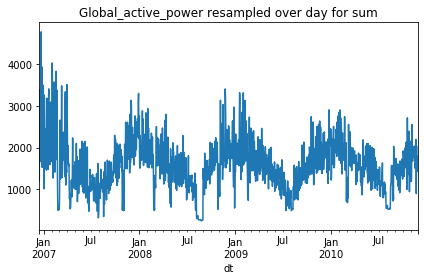

In [37]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   



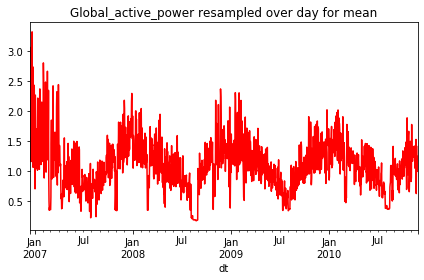

In [38]:
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

### Se muestra media y Desv std de 'Global_intensity' por día 

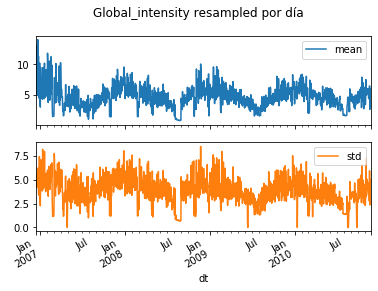

In [40]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled por día')
plt.show()

### Se muestra media y desv std de 'Global_reactive_power' por día 

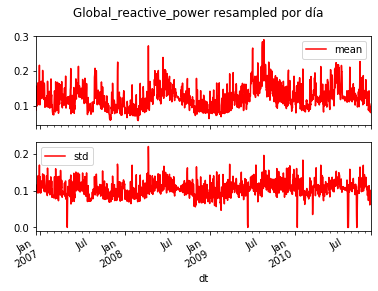

In [41]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled por día', color='red')
plt.show()

### Suma de 'Global_active_power' promediado por mes

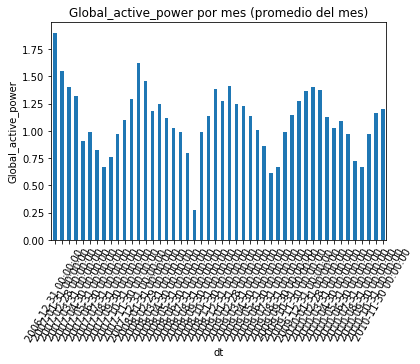

In [42]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power por mes (promedio del mes)')
plt.show()

## Media de 'Global_active_power' por trimestre

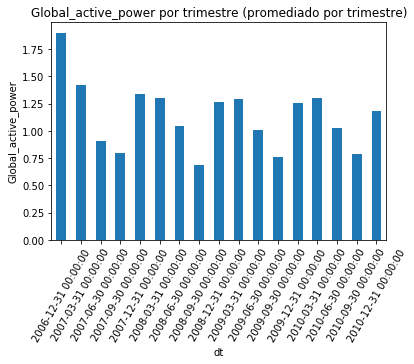

In [44]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power por trimestre (promediado por trimestre)')
plt.show()

### * Es importante notar que cuando redimensionas en un periodo largo de tiempo, se disminuye la periodicidad 

## Media de 'Voltage' por mes

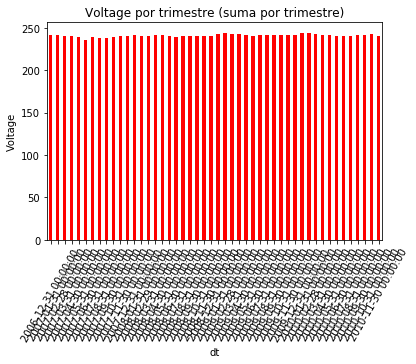

In [45]:
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage por trimestre (suma por trimestre)')
plt.show()

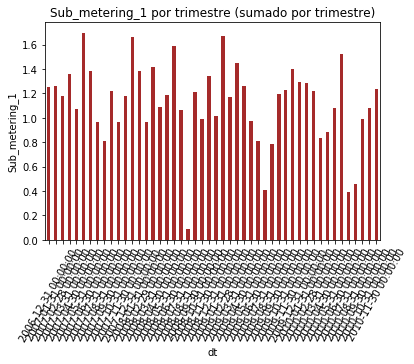

In [46]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 por trimestre (sumado por trimestre)')
plt.show()

### * Se observa de las gráficas anteriores que la media de "Voltaje" por mes es bastante mas constante que otros parámetros. 

# A continuación se compara la media de diferentes parámetros por día.

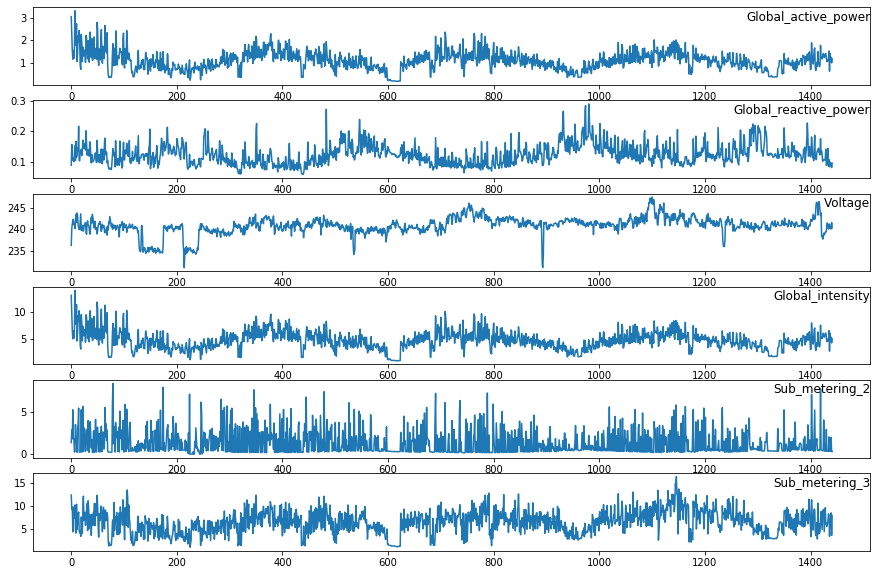

In [47]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

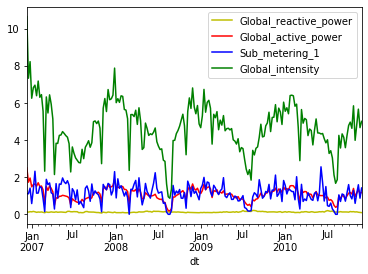

In [48]:
## resampling over week and computing mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

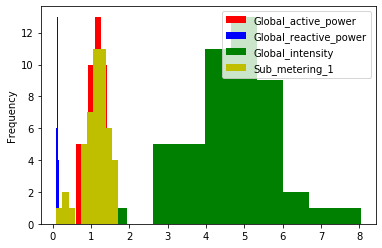

In [49]:
# Below I show hist plot of the mean of different feature resampled over month 
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

## Correlaciones entre 'Global_intensity' y  'Global_active_power'

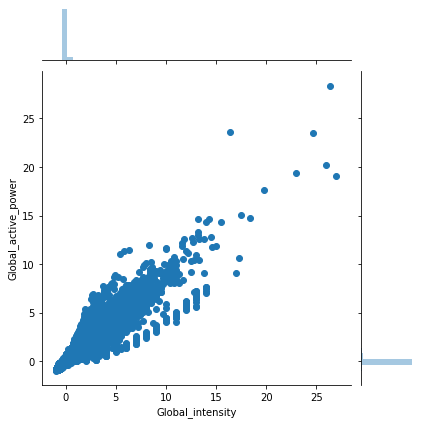

In [51]:
## La correlación entre variables 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

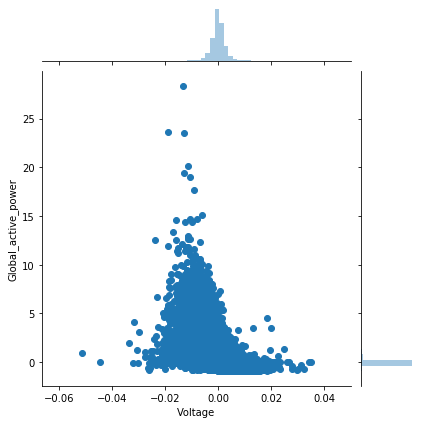

In [52]:
## La correlación entre variables 'Voltage' y 'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

### * De las gráficas anteriores se observa que  'Global_intensity' y 'Global_active_power' estan correlacionadas.  'Voltaje' y 'Global_active_power' estan menos correlacionadas.

# Correlaciones entre características

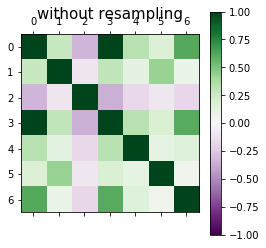

In [53]:
# Correlaciones entre columnas 
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

# Correlaciones entre la media de parámetros por mes y por año

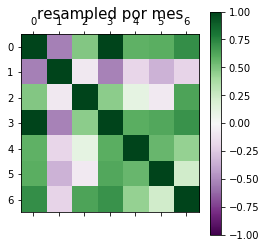

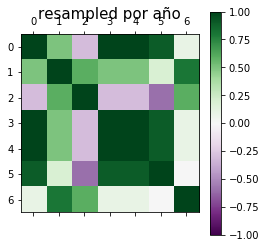

In [54]:
# Correlaciones entre la media de las caracteristicas reagrupadas (resampled) por mes


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled por mes', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled por año', size=15)
plt.colorbar()
plt.show()

### * Se puede observar que con estas técnicas se puede cambiar la correlación de los parametros.

# Machine-Leaning: LSTM Preparación de Datos

### * Se aplican técnicas de redes neuronales recurrentes LSTM 

Esta metodologia ha demostrado ser adecuada para el análisis de series de tiempo secuenciales.   

Se aborda el problema en predecir el valor Global_active_power en el tiempo (t) dada la medición de Global_active_power 

In [55]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

### * Para reducir el tiempo computacional, se calcula sobre promedios por hora en lugar del original en minutos, esto reduce los datos de calculo de 2075259 a 34589 pero mantiene la estrucura de los datos como se vió arriba.   

In [56]:
## Agrupación (resampling) de los datos por hora 
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

## * Nota: Se normalizan los datos entre [0,1]. 

In [57]:

values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


### * Arriba se muestran 7 variables de entrada (input series) y 1 variable de salida para 'Global_active_power' . 

# Separación de datos en entrenamiento y validación

### * Primero separamos los datos en dos conjuntos, de entrenamiento y validación. Para acelerar el entrenamiento del modelo, solo entrenamos con el primer año y evaluamos con los siguientes 3 años.

In [74]:
# Partir el conjunto en subconjuntos: train y test
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


# Arquitectura del Modelo

### 1)  LSTM con 100 neuronas en la primer capa 
### 3) dropout 20%
### 4) 1 neurona de salida para predecir Global_active_power. 
### 5) La entrada es de un "tiempo" con 7 parametros.
### 6) Se usa en Error Medio Absoluto "Mean Absolute Error (MAE)" como función de error y como optimizador una versión Adam del Gradiente Estocastico Descendente.
### 7) El modelo se entrenará con 20 épocas con un tamaño de bloque de 70.



Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 6s - loss: 0.0206 - val_loss: 0.0122
Epoch 2/20
 - 3s - loss: 0.0128 - val_loss: 0.0111
Epoch 3/20
 - 2s - loss: 0.0116 - val_loss: 0.0101
Epoch 4/20
 - 2s - loss: 0.0109 - val_loss: 0.0095
Epoch 5/20
 - 2s - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
 - 2s - loss: 0.0106 - val_loss: 0.0092
Epoch 7/20
 - 2s - loss: 0.0105 - val_loss: 0.0092
Epoch 8/20
 - 2s - loss: 0.0105 - val_loss: 0.0092
Epoch 9/20
 - 2s - loss: 0.0104 - val_loss: 0.0093
Epoch 10/20
 - 2s - loss: 0.0105 - val_loss: 0.0092
Epoch 11/20
 - 3s - loss: 0.0104 - val_loss: 0.0093
Epoch 12/20
 - 2s - loss: 0.0104 - val_loss: 0.0093
Epoch 13/20
 - 2s - loss: 0.0105 - val_loss: 0.0093
Epoch 14/20
 - 2s - loss: 0.0104 - val_loss: 0.0094
Epoch 15/20
 - 2s - loss: 0.0104 - val_loss: 0.0093
Epoch 16/20
 - 2s - loss: 0.0104 - val_loss: 0.0093
Epoch 17/20
 - 2s - loss: 0.0104 - val_loss: 0.0093
Epoch 18/20
 - 2s - loss: 0.0104 - val_loss: 0.0092
Epoch 19/20
 - 2s - loss

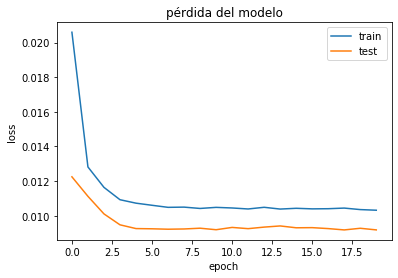

In [75]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pérdida del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()




In [76]:
test_X.shape

(25828, 1, 7)

In [77]:
test_X[0]

array([[0.36525355, 0.08458889, 0.47831591, 0.35341942, 0.        ,
        0.00897344, 0.80897138]])

In [78]:
test_X.shape[0]

25828

In [79]:
# Realizar una predicción
yhat = model.predict(test_X)

In [80]:
yhat

array([[0.34271097],
       [0.36120588],
       [0.41526324],
       ...,
       [0.28225803],
       [0.2993019 ],
       [0.21422638]], dtype=float32)

In [82]:
test_X = test_X.reshape((test_X.shape[0], 7))
test_X.shape

(25828, 7)

In [83]:
# invertir  escala para la prediccion
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.617
